# Importing the required modules

In [1]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules for lstm
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping

# Module for facebook prophet
import prophet

# Modules used for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import model

# Modules used for preprocessing
from datetime import datetime, timedelta
import preprocess
from model import Model

# Modules used for object oriented programming
from abc import ABC, abstractmethod

# Module for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# For suppressing status messages from Facebook Prophet
import logging
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

Importing plotly failed. Interactive plots will not work.


# Consolidating the data

In [2]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True, stationary=False)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [3]:
electricity = electricity[366:]

In [4]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [5]:
weather = pd.merge(temperature, precipitation, on='date', how='inner').set_index("date")

# SARIMAX

In [6]:
# class for SARIMAX model
class SARIMAX_model(Model):
    
    def __init__(self, data, exogs, cluster: str, start_index = 0, window_stride = 28):
        """
         The constructor for the abstract class Model for standardize evaluation

         Args:
            data: the actual time series that needs to be predicted.
            exogs: the exogeneous variables particularly for SARIMAX.
            cluster: the cluster data which needs to be used (cluster_1 or cluster_0).
            window_stride: the stride (in days) for moving the train-test window; defaults to 28 days.

         Returns:
            - An object of abstract class SARIMA.
        """
        super().__init__(data, cluster, start_index, window_stride)
        self.exogs = exogs
    
    # trains the model
    def train_model(self, train, train_idx):
        model = SARIMAX(endog = train[self.cluster], 
                        exog = self.exogs[train_idx[0]: train_idx[1]], 
                        order = (1, 1, 0), 
                        seasonal_order = (1, 1, 0, 12))
        return model.fit()
    
    # obtains the forecasts for next five time steps
    def get_forecasts(self, test, test_idx):
        return self.trained_model.predict(start = self.data.index[test_idx[0]], 
                                        end = self.data.index[test_idx[0]] + timedelta(len(test) - 1),
                                        exog = self.exogs[test_idx[0]: test_idx[1]])

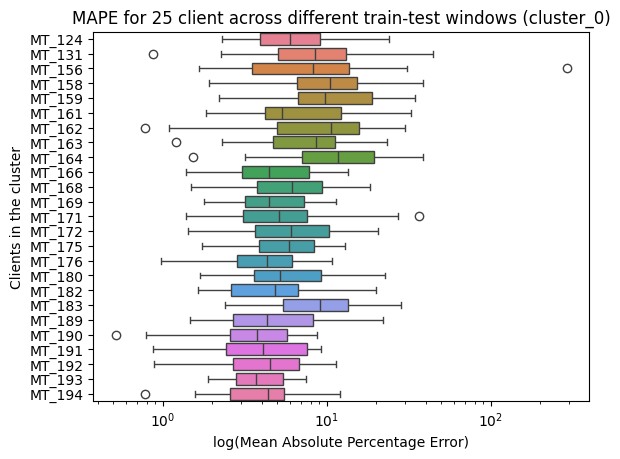

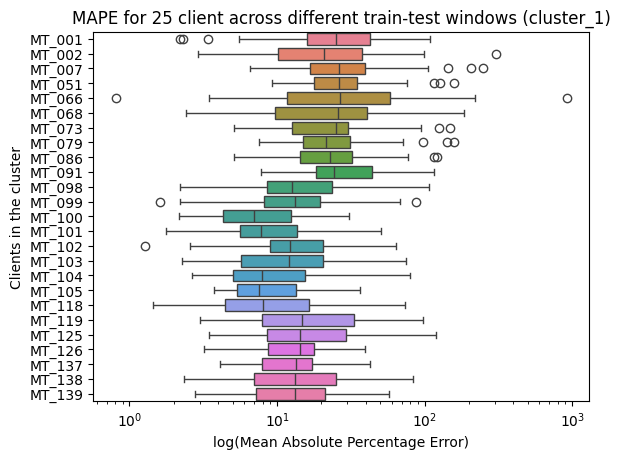

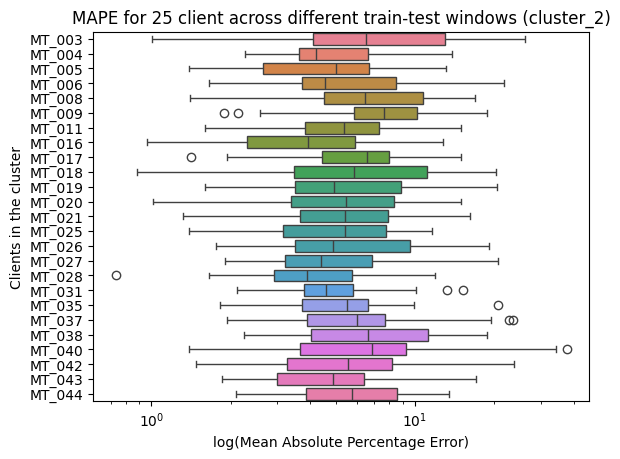

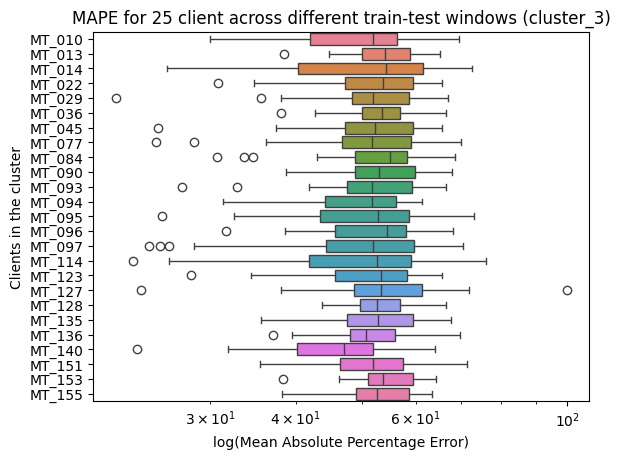

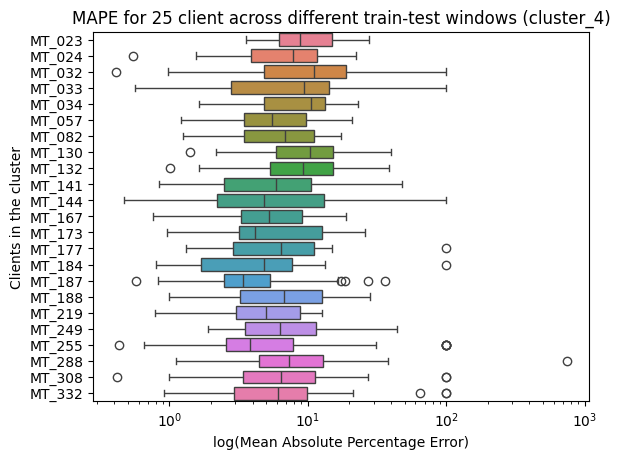

In [7]:
c = ["cluster_0", "cluster_1", "cluster_2", "cluster_3", "cluster_4"]
models = []
for i in c:
    m = SARIMAX_model(electricity, weather[366:], i, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_client(25)
    models.append(m)

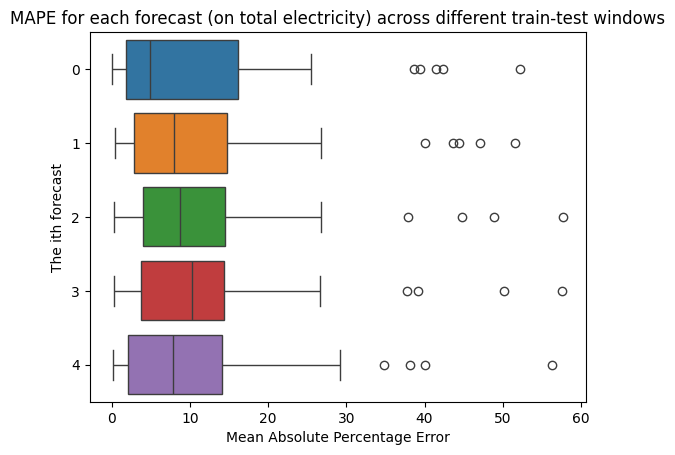

In [8]:
m.mape_boxplot_by_step(models)

# Facebook Prophet

In [9]:
class FacebookProphet_model(Model):
    
    def __init__(self, exogs, data, cluster, start_index = 0, window_stride = 28, holidays=True):
        super().__init__(data, cluster, start_index, window_stride)
        self.exogs = exogs
        self.holidays = holidays

    def restructure(self, df):
        df = df.reset_index()
        df["date"] = pd.to_datetime(df["date"])
        df = df.merge(self.exogs.reset_index())
        df = df.rename({"date": "ds", self.cluster:"y"}, axis=1)
        return df

    def train_model(self, train, train_idx):
        model = prophet.Prophet()
        for col in self.exogs.columns:
                model.add_regressor(col)

        if self.holidays:
            # Add Portugal holidays - helps catch outliers around New Year
            model.add_country_holidays(country_name='Portugal')

        #print(train.columns, self.exogs.columns)
        train = self.restructure(train)
        return model.fit(train.reset_index())
    
    def get_forecasts(self, test, test_idx):

        df = self.trained_model.make_future_dataframe(periods = self.ts_test)

        df = self.restructure(df.rename({"ds": "date"}, axis = 1)).drop(["index"], axis = 1)

        return self.trained_model.predict(df)["yhat"][self.ts_train:self.ts_train + self.ts_test]

    # Plot the results of each forecast
    def train_plot(self, n_forecast):
        diff = n_forecast*self.ts_window_stride
        train_idx = [min(diff, self.MAX_IDX), min(self.ts_train + diff, self.MAX_IDX)]
        test_idx = [min(self.ts_train + diff, self.MAX_IDX), min(self.ts_train + self.ts_test + diff, self.MAX_IDX)]
        
        train = self.data[train_idx[0]: train_idx[1]][[self.cluster]]
        test = self.data[test_idx[0]: test_idx[1]][[self.cluster]]

        # standardizing the train and test data
        train_std, test_std = self.standardize(train, test)

        # training the model
        self.trained_model = self.train_model(train_std, train_idx)

        plt.scatter(train.reset_index()['date'], train[self.cluster], c='b')
        plt.scatter(test.reset_index()['date'], test[self.cluster], c='r')
        
        df = self.trained_model.make_future_dataframe(periods = self.ts_test)

        df = self.restructure(df.rename({"ds": "date"}, axis = 1)).drop(["index"], axis = 1)

        forecast = self.trained_model.predict(df)[['ds', 'yhat']]

        # Destandardize for visualization
        forecast_std = self.destandardize(forecast[['yhat']])

        plt.plot(forecast['ds'], forecast_std, '-k')
        plt.xlabel('Date')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Total electricity consumption, kWh')
        plt.legend(['Train actual', 'Test actual', 'Prediction'])

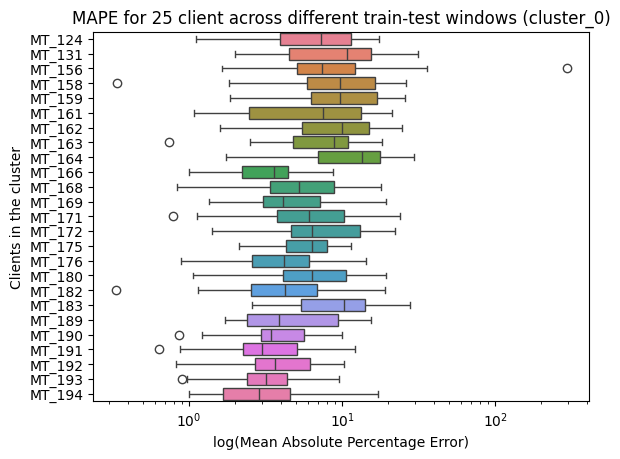

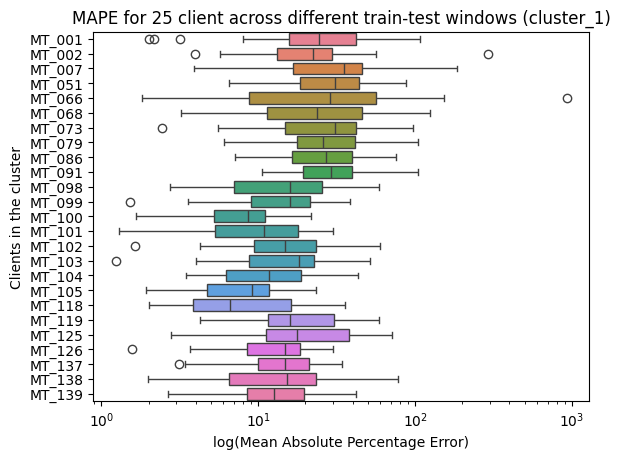

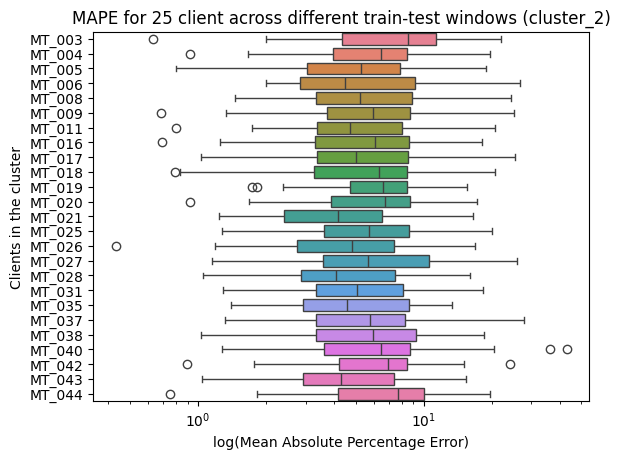

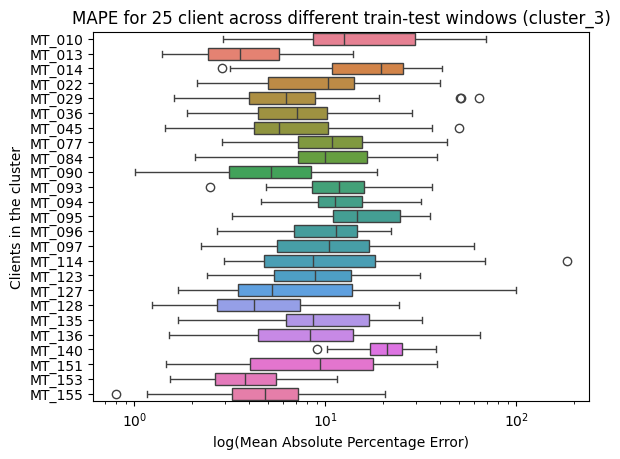

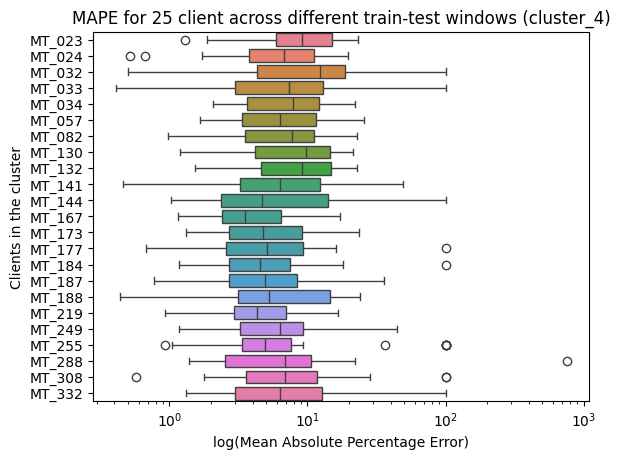

In [10]:
c = ["cluster_0", "cluster_1", "cluster_2", "cluster_3", "cluster_4"] 
models = []
for i in c:
    m = FacebookProphet_model(weather[366:], electricity, i, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_client(25)
    models.append(m)

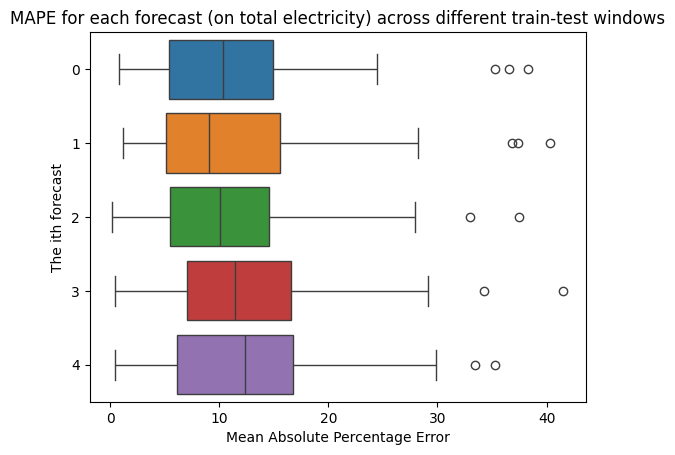

In [12]:
m.mape_boxplot_by_step(models)

# LSTM

In [46]:
class LSTM_model(Model):
    
    def __init__(self, exogs, data, cluster, params: dict, start_index = 0, window_stride = 28):
        self.exogs = exogs
        data["date"] = pd.to_datetime(data["date"])
        data = data.merge(weather.reset_index())
        self.params = params
        super().__init__(data, cluster, start_index, window_stride)
        self.ts_train = 365

    def restructure(self, X):
        
        x = np.reshape(X[["tmin", "tmax", "precip"]].values, (len(X), 1, 3))
        y = X[self.cluster].values
        
        return x, y

    def train_model(self, x_train, y_train):        
        regressor = Sequential()
        regressor.add(Bidirectional(LSTM(units=self.params["num_units"], 
                                         activation=self.params["activation_function"], 
                                         return_sequences=True), 
                                         input_shape=(1,3)))
        regressor.add(Dropout(0.2))
        regressor.add(LSTM(units=30, activation=self.params["activation_function"], return_sequences=True))
        regressor.add(Dropout(0.2))
        regressor.add(LSTM(units=15, activation=self.params["activation_function"]))
        regressor.add(Dropout(0.3))
        regressor.add(BatchNormalization())
        regressor.add(Dense(units=64, activation='relu'))
        regressor.add(Dropout(0.2))
        regressor.add(Dense(units=1))

        regressor.compile(optimizer = self.params["optimizer"], loss = self.params["loss_function"])

        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
        regressor.fit(x_train[:self.ts_train - 10], y_train[:self.ts_train - 10], batch_size = self.params["batch_size"], 
                      epochs = self.params["num_epochs"], verbose = 0,
                      validation_data = (x_train[self.ts_train - 10:], y_train[self.ts_train - 10:]),
                      callbacks = [early_stopping])

        return regressor
    
    def get_forecasts(self, x_test):

        return self.trained_model.predict(x_test).flatten()
    
    def cross_validate(self):
      
      train_idx = [0, self.ts_train]
      test_idx = [self.ts_train, self.ts_train + self.ts_test]

      for split_id in range(50):

         if test_idx[0] == test_idx[1]:
            break 
         
         cols = [self.cluster, "tmin", "tmax", "precip"]
         train = self.data[train_idx[0]: train_idx[1]][cols]
         test = self.data[test_idx[0]: test_idx[1]][cols]

         self.scaler, train, test = self.standardize(train, test)

         x_train, y_train = self.restructure(train)
         x_test, y_test = self.restructure(test)

         self.trained_model = self.train_model(x_train, y_train)

         preds = self.get_forecasts(x_test)
         
         self.forecasts[split_id] = {"pred": list(preds),
                                     "train_date_range": train_idx,
                                     "test_date_range": test_idx}
   
         test_np = y_test.flatten()
         mape_by_forecast = np.abs((test_np - self.forecasts[split_id]["pred"])/(test_np))*100
         self.forecasts[split_id]["mape_by_forecast"] = mape_by_forecast

         train_idx = [train_idx[0] + self.ts_window_stride, 
                     min(train_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
         test_idx = [test_idx[0] + self.ts_window_stride, 
                     min(test_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
        
         if test_idx[0] > len(self.data):
            break
    
    def mape_boxplot_by_step(self, models):

      clusters = ["cluster_"+str(i) for i in range(5)]
      total_consump = dict()
      for i in self.forecasts:

         total_preds = np.zeros(self.ts_test)
         for c in clusters:

            pred = self.destandardize(np.array(models[int(c[-1])].forecasts[i]["pred"]).reshape(-1,1),
                                      models[int(c[-1])].scaler).flatten()
            total_preds += pred

         start,end = self.forecasts[i]["test_date_range"]
         test_np = self.data[start:end].sum(axis = 1).values.flatten()
         mape_by_forecast = np.abs((test_np - total_preds)/(test_np))*100
         total_consump[i] = mape_by_forecast

      t = dict()
      for i in total_consump:
         t[i] = total_consump[i]

      df = pd.DataFrame.from_dict(t, orient = "index")

      # plotting th boxplot
      sns.boxplot(df, orient = 'h', log_scale = False)

      plt.xlabel("Mean Absolute Percentage Error")
      plt.ylabel("The ith forecast")
      plt.title("MAPE for each forecast (on total electricity) across different train-test windows")
      plt.show() 
   
    def mape_boxplot_by_step(self, models):

      clusters = ["cluster_"+str(i) for i in range(5)]
      total_consump = dict()
      for i in self.forecasts:

         total_preds = np.zeros(self.ts_test)
         for c in clusters:

            pred = self.destandardize(np.array(models[int(c[-1])].forecasts[i]["pred"]).reshape(-1,1),
                                      models[int(c[-1])].scaler).flatten()
            total_preds += pred

         start,end = self.forecasts[i]["test_date_range"]
         test_np = self.data[start:end].sum(axis = 1).values.flatten()
         mape_by_forecast = np.abs((test_np - total_preds)/(test_np))*100
         total_consump[i] = mape_by_forecast

      t = dict()
      for i in total_consump:
         t[i] = total_consump[i]

      df = pd.DataFrame.from_dict(t, orient = "index")

      # plotting th boxplot
      sns.boxplot(df, orient = 'h', log_scale = False)

      plt.xlabel("Mean Absolute Percentage Error")
      plt.ylabel("The ith forecast")
      plt.title("MAPE for each forecast (on total electricity) across different train-test windows")
      plt.show() 
   
    def mape_boxplot_by_step(self, models):

      clusters = ["cluster_"+str(i) for i in range(5)]
      total_consump = dict()
      for i in m.forecasts:

         total_preds = np.zeros(self.ts_test)
         is_computable = True
         for c in clusters:

            if len(models[int(c[-1])].forecasts[i]["pred"]) != 5:
                is_computable = False
                continue

            cols = [c, "tmin", "tmax", "precip"]
            temp = pd.DataFrame(np.zeros((5, 4)), columns = cols)
            temp[c] = np.array(models[int(c[-1])].forecasts[i]["pred"])
            pred = self.destandardize(temp,
                                   models[int(c[-1])].scaler)
            

            total_preds += pd.DataFrame(pred, columns=cols)[c].values

         start,end = m.forecasts[i]["test_date_range"]
         if not is_computable:
             continue
         test_np = self.data[start:end].set_index("date")[clusters].sum(axis = 1).values.flatten()
         mape_by_forecast = np.abs((test_np - total_preds)/(test_np))*100
         total_consump[i] = mape_by_forecast

      t = dict()
      for i in total_consump:
         t[i] = total_consump[i]

      df = pd.DataFrame.from_dict(t, orient = "index")

      # plotting th boxplot
      sns.boxplot(df, orient = 'h', log_scale = False)

      plt.xlabel("Mean Absolute Percentage Error")
      plt.ylabel("The ith forecast")
      plt.title("MAPE for each forecast (on total electricity) across different train-test windows")
      plt.show() 

    def mape_boxplot_by_client(self, num_clients: int):

      """
      Plots the MAPE for each client considering the cluster predictions as individual client predictions

      Note: 
         - the individual client electricity consumption is standardized based on the train dataset for comparison.
         - the MAPE values cannot exceed 100
      
      Args:
         num_clients: the number of clients for which the evaluation needs to be done.
      """
      
      t = []
      self.s = []
      with open("clusters.json", "r") as f:
            
            # extracting the individual clients in the cluster
            clusters = json.load(fp = f)
            cluster = clusters[self.cluster[-1]]

            # obtaining the individual client electricity consumption
            l = preprocess.preprocess_modelling(as_numpy = False, 
                                                clustered = False, 
                                                stationary = False)
            
            # computing MAPE based on each client in the cluster
            # for every train-test window
            for i in cluster:
               mape = []
               for j in self.forecasts:

                  # getting and standardizing the train and test data
                  train_start, train_end = self.forecasts[j]["train_date_range"]
                  test_start, test_end = self.forecasts[j]["test_date_range"]
                  train = l[self.start_idx:][[i]][train_start:train_end]
                  test = l[self.start_idx:][[i]][test_start:test_end]

                  if len(test) != self.ts_test:
                     continue

                  _, train, test = self.standardize(train, test)
                     
                  test[test == 0] = 1e18

                  self.s.append(test)
                  # computing and storing the MAPE
                  cols = ["cluster_0", "tmin", "tmax", "precip"]
                  temp = pd.DataFrame(np.zeros((5, 4)), columns = cols)
                  temp["cluster_0"] = np.array(self.forecasts[j]["pred"])

                  pred = self.destandardize(temp, self.scaler)

                  pred1 = pd.DataFrame(pred, columns = cols)["cluster_0"].values
                  temp["cluster_0"] = test.values.flatten()

                  #print(self.destandardize(temp, self.scaler))
                  pred2 = pd.DataFrame(self.destandardize(temp, self.scaler), columns = cols)["cluster_0"].values

                  #print(pred1, pred2)
                  m = mean_absolute_percentage_error(pred2, 
                                                     pred1)*100
                  mape.append(m)
               
               t.append(mape)
            

            self.mape_ = dict(zip(cluster[0:num_clients], t))

            self.d = pd.DataFrame.from_dict(self.mape_, orient="columns")
            # plotting the boxplot
            sns.boxplot(self.d,
                        log_scale=True, orient='h')

            plt.xlabel("log(Mean Absolute Percentage Error)")
            plt.ylabel("Clients in the cluster")
            plt.title(f"MAPE for {num_clients} client across different train-test windows ({self.cluster})")
            plt.show()

Epoch 117: early stopping
Restoring model weights from the end of the best epoch: 97.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Epoch 122: early stopping
Restoring model weights from the end of the best epoch: 102.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Epoch 122: early stopping
Restoring model weights from the end of the best epoch: 102.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 64.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 4.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 137: early stopping
Restoring model weights from the end of the best epoch: 117.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 46.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Epoch 104: early stopping
Restoring model weights from the end of the best epoch: 84.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
E

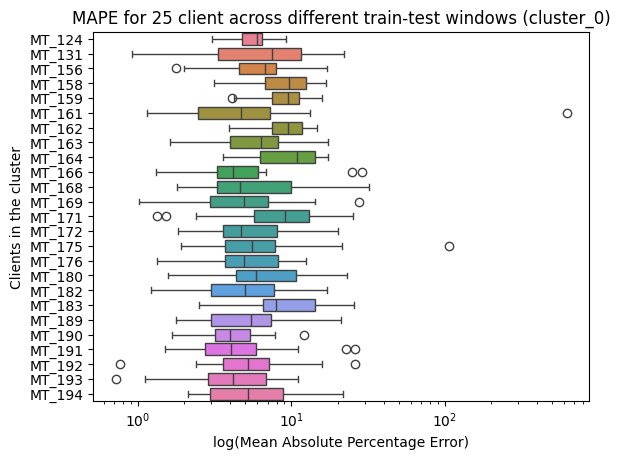

Epoch 112: early stopping
Restoring model weights from the end of the best epoch: 92.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 70.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Epoch 113: early stopping
Restoring model weights from the end of the best epoch: 93.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 75.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 25.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 46.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 45.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Epoch 88: early stopping
Restoring model weights from the end of the best epoch: 68.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 

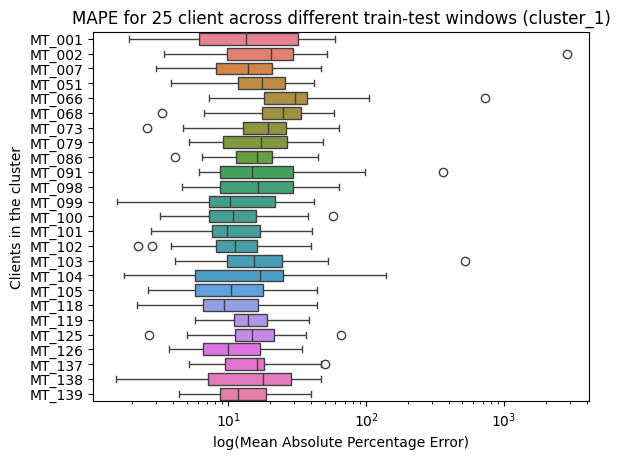

Epoch 99: early stopping
Restoring model weights from the end of the best epoch: 79.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Epoch 110: early stopping
Restoring model weights from the end of the best epoch: 90.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Epoch 80: early stopping
Restoring model weights from the end of the best epoch: 60.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 3.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 111: early stopping
Restoring model weights from the end of the best epoch: 91.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 6.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 3.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 19.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Epoch 54:

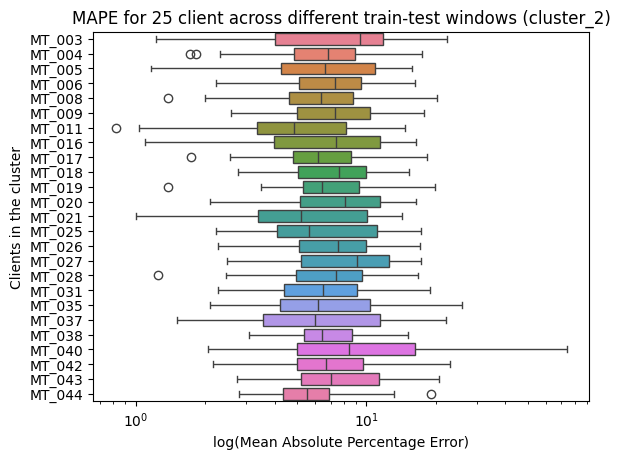

Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 7.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 13.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 19.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 14.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 12.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 27.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 38.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 39.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Epoch 23:

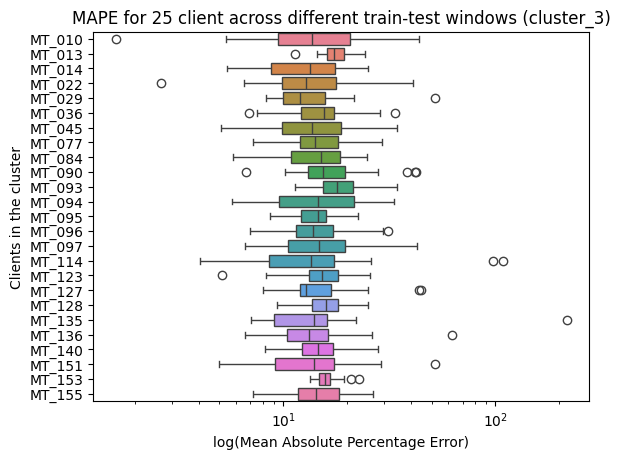

Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 24.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 73.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 69.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Epoch 88: early stopping
Restoring model weights from the end of the best epoch: 68.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 12.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 2.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Epoch 46: e

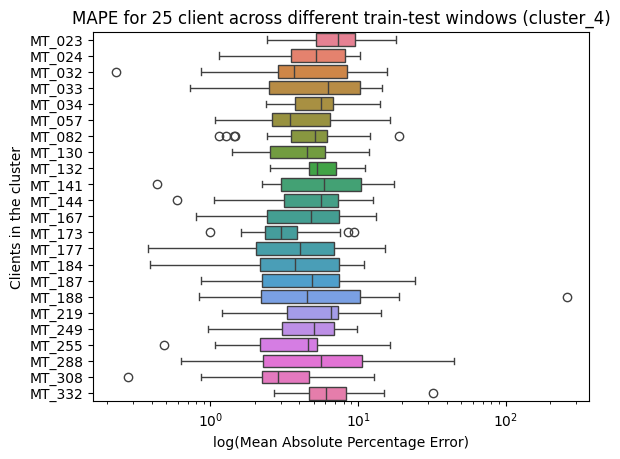

In [47]:
params = {
    "num_units": 60,
    "activation_function": 'relu',
    "optimizer": "adam",
    "loss_function": "mse",
    "batch_size": 32,
    "num_epochs": 300
}

c = ["cluster_0", "cluster_1", "cluster_2", "cluster_3", "cluster_4"] 
models = []
for i in c:
    m = LSTM_model(weather[366:].reset_index(), electricity.reset_index(), 
                   i, params, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_client(25)
    models.append(m)

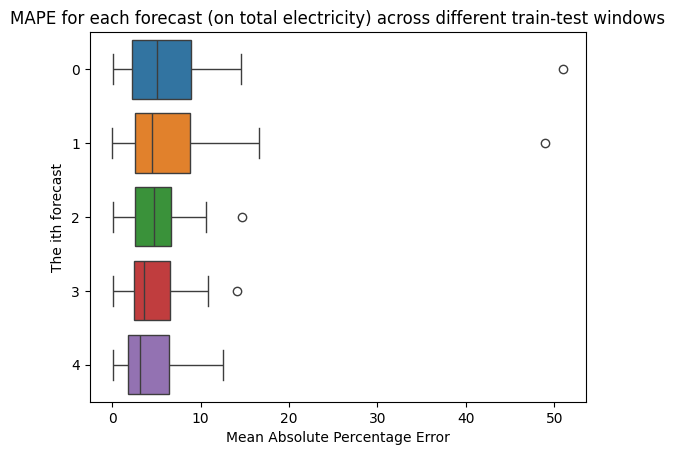

In [ ]:
m.mape_boxplot_by_step(models)